In [1]:
import numpy as np 
import tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#Import the necessary packages and 
(train_set, train_label), (test_set, test_label) = mnist.load_data()
train_set, train_label = train_set[:20000], train_label[:20000]

In [3]:
train_set.shape

(20000, 28, 28)

The code below was use to help look for the indices of a particular digit by trial and error. In a sense I was relabeling the data, so I decided to use the labels to help me focus on the sensitiviy analysis.


 0


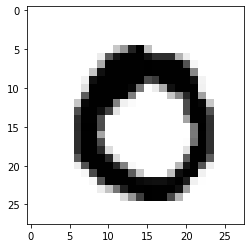

In [4]:
#I use this piece of code, to check the image for the given index
plt.imshow(train_set[56][:,:], cmap = plt.cm.binary)
print("\n", train_label[56])


# Start of tests in preparation to run longer simulations

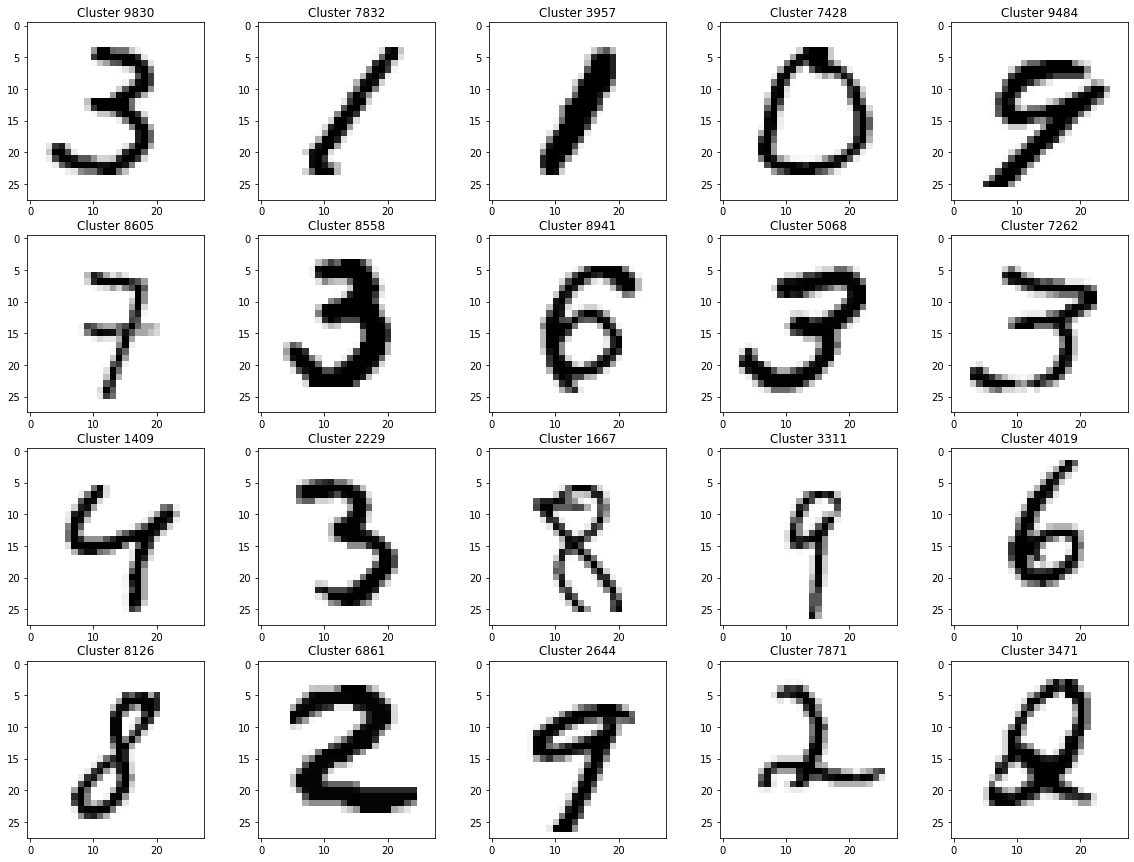

In [5]:
#The lines of code below allow for randomly generating 20 numbers
#uniformly on the interval (0, train_set.shape[0])
rng = np.random.default_rng()
fig,axs = plt.subplots(4,5, figsize = (20,15))
iV = rng.integers(0, 10000, dtype=np.int32, size=20, endpoint=True)

#The number correspoding to the digit is plotted for manual labeling the
#cluster number is the index of the image in the dataset
for i in range(len(iV)):
  axs[i//5][i%5].imshow(train_set[iV[i]][:,:], cmap = plt.cm.binary)
  axs[i//5][i%5].set_title(f'Cluster {iV[i] + 1}')

# Run this line of code

In [5]:
#Reshape the images as a 784d vector
train_set = train_set.reshape(20000,-1)/255
print(train_set.shape)

(20000, 784)


# Implementing KMeans on MNIST to cluster data

This is the code from the our midterm project. Since it was not vectorized, it proved challeging to run the experiments in reasonable time. Below are some of the erly experiments performed. This was also a sanitiy check that the vectorized code was working correctly.

In [14]:
def calcSqDistances(X, Kmus):
    N = X.shape[0]
    K = Kmus.shape[0]

    #Note we have 20,000 28x28 images and Kmus contains K images
    distanceMtx = np.zeros((N, K))
    for o in range(N):
      for p in range(K):
        distanceMtx[o][p] = np.linalg.norm(X[o]-Kmus[p])
    return distanceMtx


def determineRnk(sqDmat):
    #Number of rows
    m = sqDmat.shape[0]
    #Number of columns
    n = sqDmat.shape[1]

    rankMatrix = np.zeros((m,n))
    for i in range(m):
      tempIndex = np.argmin(sqDmat[i][:])
      rankMatrix[i][tempIndex] = 1
    return rankMatrix

def recalcMus(X, Rnk):
    N = Rnk.shape[0]
    K = Rnk.shape[1]
    KmusT = np.zeros((K,X.shape[1]))

    for p in range(K):
      temp = np.zeros(X[0].shape)
      tR = Rnk.transpose()
      tempSum = np.sum(tR[p][:])
      for i in range(N):
        temp = temp + Rnk[i][p]*X[i][:]
      KmusT[p] = temp/tempSum
    return KmusT

In [7]:
#Fucntions provided from the midterm to graph the clusters.   
def get_cluster_plot(Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(2,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

def get_cluster_plot_20(Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(4,5, figsize = (20,15))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

# Experiments with original midterm code.

In [ ]:
#Modified Kmeans fucntion that allows for more control of the initial guess for 
#the cluster centers
def runKMeans_E(K, Kmus):
    maxiters = 1000
    for iter in range(maxiters):
      sqDmat = calcSqDistances(train_set, Kmus)
      Rnk = determineRnk(sqDmat)
      KmusOld = Kmus
      Kmus = recalcMus(train_set, Rnk)

      if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            break

    return Kmus, iter

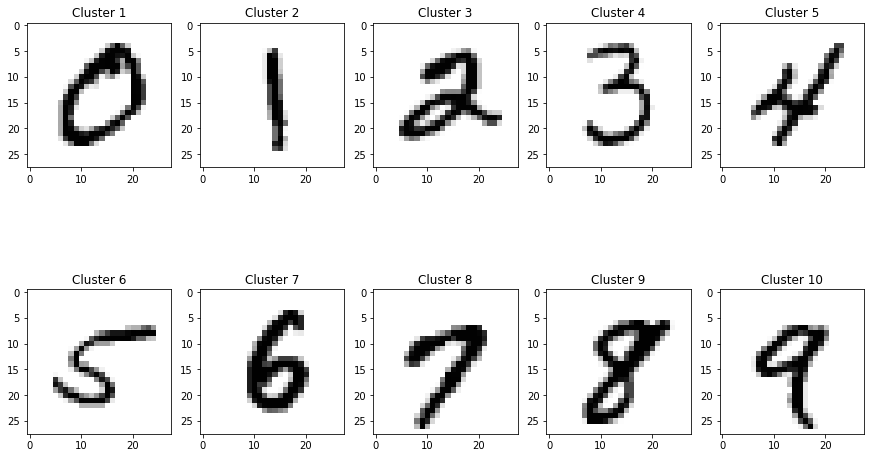

In [ ]:
#In this experiment, we start with an initla guess of digits 0-9 in order

#This array has the indices for  the inital cluster center guesses
initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])
#From the indices, we read the corresponding images
initial_Kmus_b = train_set[initial_inds_b[0:10],:]

#Plot the iniial guess for the cluster centers
get_cluster_plot(initial_Kmus_b)

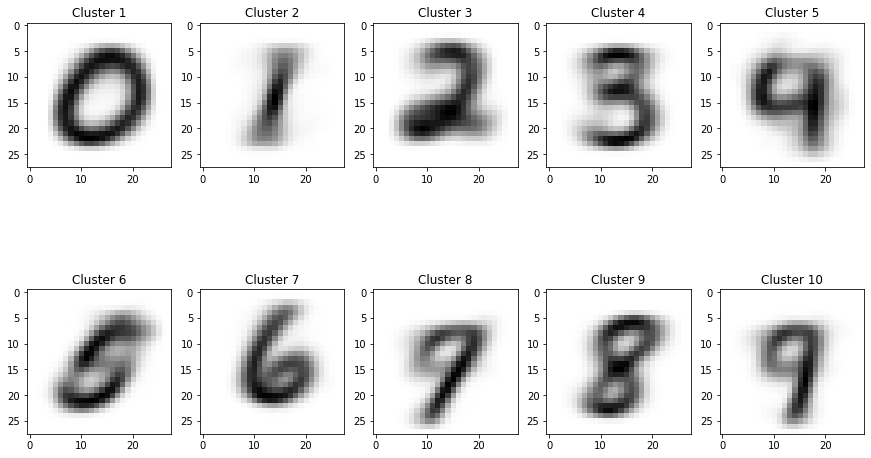

In [ ]:
Kmus_b, ind_bb = runKMeans_E(10, initial_Kmus_b)
#Output of kmean algotihm with 0-9 as initial guess
get_cluster_plot(Kmus_b) 

Below, we put the indices of other ten 1's in the dataset and compute the perturbation as the 2-norm differnce of the original digit with its replacement.
We then run the k-means algorithm with the inial guess and record the number of
iterations, I chose to print the output to avoid the ~15 minutes it takes for the completion

In [ ]:
test_ind = np.array([3,6,14,4312,9563,3957,2317,2256,3488])
dx = []
itV = []
for i in range(9):
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])
  initial_inds_b[0] = test_ind[i]
  dx.append(np.linalg.norm(train_set[8,:] - train_set[test_ind[i],:]))
  initial_Kmus_b= train_set[initial_inds_b[0:10],:]
  Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)
  itV.append(ind_t)

  print(dx)
  print(itV)

[0.03309786829315779]
[47]
[0.03309786829315779, 0.01785241268054353]
[47, 57]
[0.03309786829315779, 0.01785241268054353, 0.014505938356993155]
[47, 57, 48]
[0.03309786829315779, 0.01785241268054353, 0.014505938356993155, 0.03199967243968925]
[47, 57, 48, 42]
[0.03309786829315779, 0.01785241268054353, 0.014505938356993155, 0.03199967243968925, 0.018435220030476554]
[47, 57, 48, 42, 58]
[0.03309786829315779, 0.01785241268054353, 0.014505938356993155, 0.03199967243968925, 0.018435220030476554, 0.035922251240910294]
[47, 57, 48, 42, 58, 48]
[0.03309786829315779, 0.01785241268054353, 0.014505938356993155, 0.03199967243968925, 0.018435220030476554, 0.035922251240910294, 0.03459828933954627]
[47, 57, 48, 42, 58, 48, 35]
[0.03309786829315779, 0.01785241268054353, 0.014505938356993155, 0.03199967243968925, 0.018435220030476554, 0.035922251240910294, 0.03459828933954627, 0.047041391106687515]
[47, 57, 48, 42, 58, 48, 35, 40]
[0.03309786829315779, 0.01785241268054353, 0.014505938356993155, 0.031

IndexError: ignored

Above I made a mistake on the number of new indices that's why i got this error. The last index should've been 8 since I only had 9 elements in test_ind vector. If run again will not give an error

Below test_ind has another 10 different indices of 1's found in the data set.
I was testing how long it would take my code to run, so that I could decide how many indices I could use.

In [ ]:
test_ind = np.array([3759,4716,1549,7858,8219,2104,5835,2498,8665,1116])
dx2 = []
itV2 = []
for i in range(10):
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])
  initial_inds_b[0] = test_ind[i]
  dx2.append(np.linalg.norm(train_set[8,:] - train_set[test_ind[i],:]))
  initial_Kmus_b= train_set[initial_inds_b[0:10],:]
  Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)
  itV2.append(ind_t)

  print(dx2)
  print(itV2)

[0.03953698802819678]
[36]
[0.03953698802819678, 0.03127301002799423]
[36, 70]
[0.03953698802819678, 0.03127301002799423, 0.0371718715799267]
[36, 70, 41]
[0.03953698802819678, 0.03127301002799423, 0.0371718715799267, 0.03886134628236482]
[36, 70, 41, 57]
[0.03953698802819678, 0.03127301002799423, 0.0371718715799267, 0.03886134628236482, 0.031186783696822755]
[36, 70, 41, 57, 46]
[0.03953698802819678, 0.03127301002799423, 0.0371718715799267, 0.03886134628236482, 0.031186783696822755, 0.043244594073920346]
[36, 70, 41, 57, 46, 67]
[0.03953698802819678, 0.03127301002799423, 0.0371718715799267, 0.03886134628236482, 0.031186783696822755, 0.043244594073920346, 0.03156699209893113]
[36, 70, 41, 57, 46, 67, 41]
[0.03953698802819678, 0.03127301002799423, 0.0371718715799267, 0.03886134628236482, 0.031186783696822755, 0.043244594073920346, 0.03156699209893113, 0.03513135466105802]
[36, 70, 41, 57, 46, 67, 41, 65]
[0.03953698802819678, 0.03127301002799423, 0.0371718715799267, 0.03886134628236482,

Since I wanted to use at least 100 indices to create a plot of change in initial guess vs change in number of iterations, I changed to using the vecotized k means code from section. This is the implementation that you can see below.

# Vectorized k-means code (Run code below)

In [6]:
def calcSqDistances(X, kmus):
  return ((-2*X.dot(kmus.T) + np.sum(np.multiply(kmus,kmus), axis=1).T).T + np.sum(np.multiply(X,X), axis=1)).T

In [7]:
def determineRnk(sqDmat):
  m = np.argmin(sqDmat, axis = 1)
  return np.eye(sqDmat.shape[1])[m]

In [8]:
def recalcMus(X, Rnk):
  return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T

In [9]:
def runKMeans_E(K, Kmus):
  (train_set, train_label), (test_set, test_label) = mnist.load_data()
  train_set, train_label = train_set[:10000], train_label[:10000]
  #Reshape the images as a 784d vector
  train_set = train_set.reshape(10000,-1)/255
  maxiters = 1000
  for iter in range(maxiters):
    sqDmat = calcSqDistances(train_set, Kmus)
    Rnk = determineRnk(sqDmat)
    KmusOld = Kmus
    Kmus = recalcMus(train_set, Rnk)
    
    if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
      break
  return Kmus, iter

In [10]:
#Fucntions provided from the midterm to graph the clusters.   
def get_cluster_plot(Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(2,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

def get_cluster_plot_20(Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(4,5, figsize = (20,15))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

To make things a bit easier when it came to selecting the indices for the correct digits, I decided to use the labels to get some indices and then from there I would take a random subset to use for my analysis.

# Start of longer simulations using vectorized code. Keep running the code if want to check results

In [13]:
ind_0 = []
ind_1 = []
ind_2 = []
ind_3 = []
ind_4 = []
ind_5 = []
ind_6 = []
ind_7 = []
ind_8 = []
ind_9 = []
for i in range(train_set.shape[0]):
  if(train_label[i] == 0):
    ind_0.append(i)
  elif(train_label[i] == 1):
    ind_1.append(i)
  elif(train_label[i] == 2):
    ind_2.append(i)
  elif(train_label[i] == 3):
    ind_3.append(i)
  elif(train_label[i] == 4):
    ind_4.append(i)
  elif(train_label[i] == 5):
    ind_5.append(i)
  elif(train_label[i] == 6):
    ind_6.append(i)
  elif(train_label[i] == 7):
    ind_7.append(i)
  elif(train_label[i] == 8):
    ind_8.append(i)
  elif(train_label[i] == 9):
    ind_9.append(i)
  else:
    continue

idv0 = np.array(ind_0)
idv1 = np.array(ind_1)
idv2 = np.array(ind_2)
idv3 = np.array(ind_3)
idv4 = np.array(ind_4)
idv5 = np.array(ind_5)
idv6 = np.array(ind_6)
idv7 = np.array(ind_7)
idv8 = np.array(ind_8)
idv9 = np.array(ind_9)

print(idv0.shape)
print(idv1.shape)
print(idv2.shape)
print(idv3.shape)
print(idv4.shape)
print(idv5.shape)
print(idv6.shape)
print(idv7.shape)
print(idv8.shape)
print(idv9.shape)

(1994,)
(2281,)
(1929,)
(2076,)
(1945,)
(1775,)
(1971,)
(2093,)
(1922,)
(2014,)


What you see above is the distribution for each of the digits

In the cell below, we start by testing that the vecotized version works correctly. He re we also get our base kmus vector and base index count for each cluster. 

#### This line below needs to be run

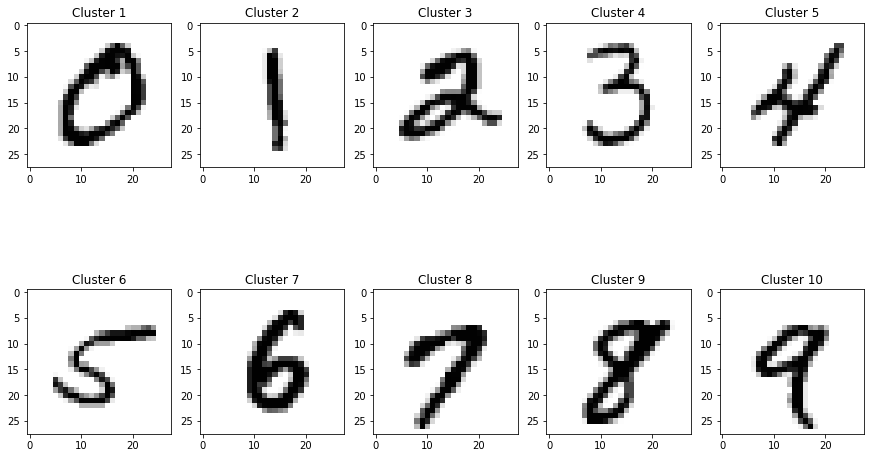

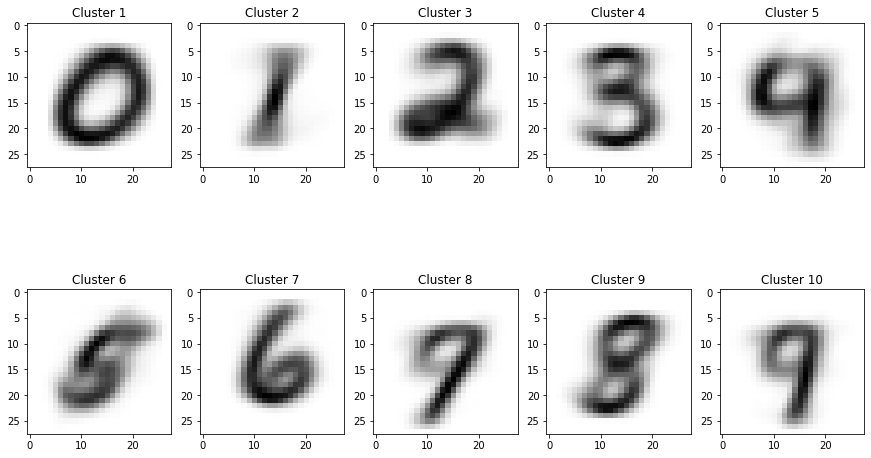

In [14]:
#Get cluster representation for K = 10 clusters

#These are the indices that we picked as our base for comparison 
initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])
#These are the images that serve as our initial guess for the cluster centers
initial_Kmus_b = train_set[initial_inds_b[0:10],:]

#Plot the 10 inital images
get_cluster_plot(initial_Kmus_b)

Kmus_b, indc_b = runKMeans_E(10, initial_Kmus_b)

get_cluster_plot(Kmus_b) #Get cluster representation for K = 10 clusters

In [18]:
test_ind = idv5[0:30]
dx = []
ditV = []
for i in range(len(test_ind)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #Change the index from the base for the appropriate digit
  initial_inds_b[5] = test_ind[i]

  #Compute the pertrubation of the new digit image with respect to the base 
  #digit image and store it in a vector
  dx.append(np.linalg.norm(train_set[1635,:] - train_set[test_ind[i],:])/2*np.linalg.norm(train_set[1635,:]))

  #Run the kmeans algorithm with the new initial guess
  initial_Kmus_b= train_set[initial_inds_b[0:10],:]
  Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)
  
  #Compute the absolute change in number of iterations
  ditV.append(np.abs(ind_t - indc_b))

  print(dx)
  print(ditV)

[37.16777309170938]
[1]
[37.16777309170938, 25.48604350699288]
[1, 7]
[37.16777309170938, 25.48604350699288, 26.719372304394685]
[1, 7, 12]
[37.16777309170938, 25.48604350699288, 26.719372304394685, 24.646639551325]
[1, 7, 12, 3]
[37.16777309170938, 25.48604350699288, 26.719372304394685, 24.646639551325, 28.266534307657086]
[1, 7, 12, 3, 7]
[37.16777309170938, 25.48604350699288, 26.719372304394685, 24.646639551325, 28.266534307657086, 31.31826494466433]
[1, 7, 12, 3, 7, 16]
[37.16777309170938, 25.48604350699288, 26.719372304394685, 24.646639551325, 28.266534307657086, 31.31826494466433, 32.00344114359112]
[1, 7, 12, 3, 7, 16, 9]
[37.16777309170938, 25.48604350699288, 26.719372304394685, 24.646639551325, 28.266534307657086, 31.31826494466433, 32.00344114359112, 38.222955149843344]
[1, 7, 12, 3, 7, 16, 9, 24]
[37.16777309170938, 25.48604350699288, 26.719372304394685, 24.646639551325, 28.266534307657086, 31.31826494466433, 32.00344114359112, 38.222955149843344, 20.51589056216611]
[1, 7, 1

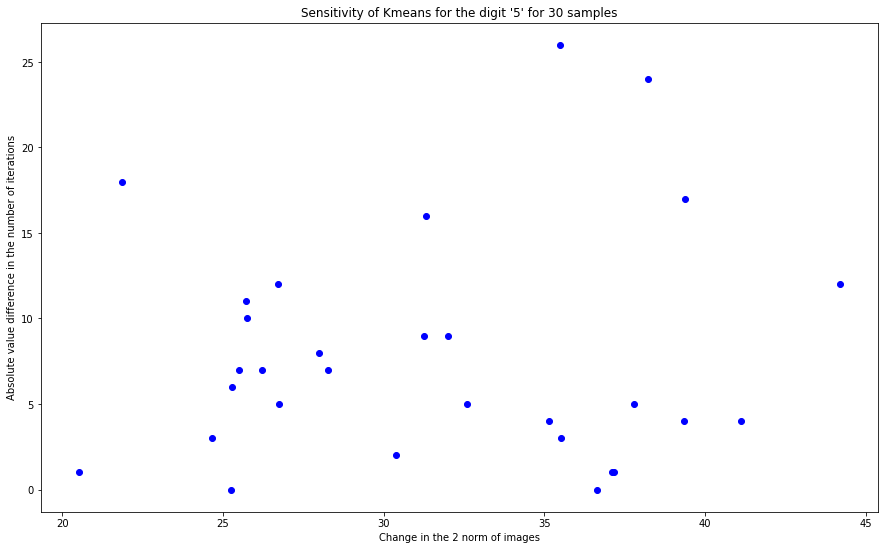

In [19]:
import pylab
import numpy as np
import math
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx,ditV, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '5' for 30 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Absolute value difference in the number of iterations")
plt.show()


In my origial run above, there was no possibilty of the old index and the new index being the same, but becasue this would could happend in the simulation for the digit zero I added an if statement ot avoid this case .

In [ ]:
test_ind = idv0[0:50]
dx0 = []
ditV0 = []
for i in range(len(test_ind)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[0] != test_ind[i]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[0] = test_ind[i]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx0.append(np.linalg.norm(train_set[1,:] - train_set[test_ind[i],:]))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV0.append(np.abs(ind_t - indc_b))

  print(dx0)
  print(ditV0)

[]
[]
[5.443159857556054]
[4]
[5.443159857556054, 9.177708982969884]
[4, 4]
[5.443159857556054, 9.177708982969884, 7.2091989166347625]
[4, 4, 3]
[5.443159857556054, 9.177708982969884, 7.2091989166347625, 8.139291028035666]
[4, 4, 3, 2]
[5.443159857556054, 9.177708982969884, 7.2091989166347625, 8.139291028035666, 9.3595044181148]
[4, 4, 3, 2, 2]
[5.443159857556054, 9.177708982969884, 7.2091989166347625, 8.139291028035666, 9.3595044181148, 8.593478567766134]
[4, 4, 3, 2, 2, 12]
[5.443159857556054, 9.177708982969884, 7.2091989166347625, 8.139291028035666, 9.3595044181148, 8.593478567766134, 11.262465860321262]
[4, 4, 3, 2, 2, 12, 3]
[5.443159857556054, 9.177708982969884, 7.2091989166347625, 8.139291028035666, 9.3595044181148, 8.593478567766134, 11.262465860321262, 9.489799051815021]
[4, 4, 3, 2, 2, 12, 3, 3]
[5.443159857556054, 9.177708982969884, 7.2091989166347625, 8.139291028035666, 9.3595044181148, 8.593478567766134, 11.262465860321262, 9.489799051815021, 7.699468467800812]
[4, 4, 3, 2

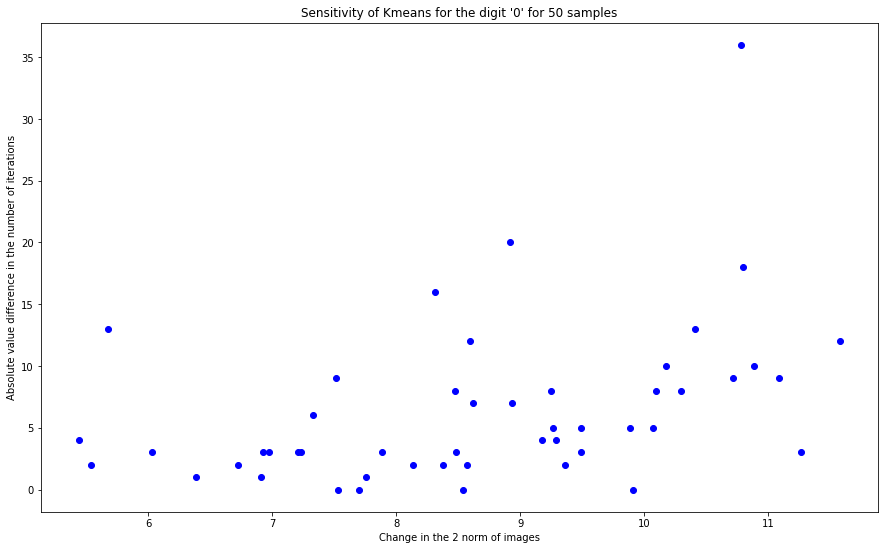

In [ ]:
import pylab
import numpy as np
import math

fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx0,ditV0, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '0' for 50 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Absolute value difference in the number of iterations")
plt.show()


After this experimentt, I decided that I should also look at the change in the 2 norm of the outout of the kmeans algorithm. Note that for the following experiment I'm using the first 30 digits '0' in the dataset using the indices stored in idv0 

In [ ]:
test_ind = idv0[0:30]
dx0p = []
ditV0p = []
do0p = []
for i in range(len(test_ind)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[0] != test_ind[i]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[0] = test_ind[i]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx0p.append(np.linalg.norm(train_set[1,:] - train_set[test_ind[i],:]))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV0.append(np.abs(ind_t - indc_b))

    #Compute the absolute change in the cluster means
    do0p.append(np.linalg.norm(Kmus_b - Kmus_t))

  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Above I used a counter to keep track of the progress, I stopped doing this on later experiments

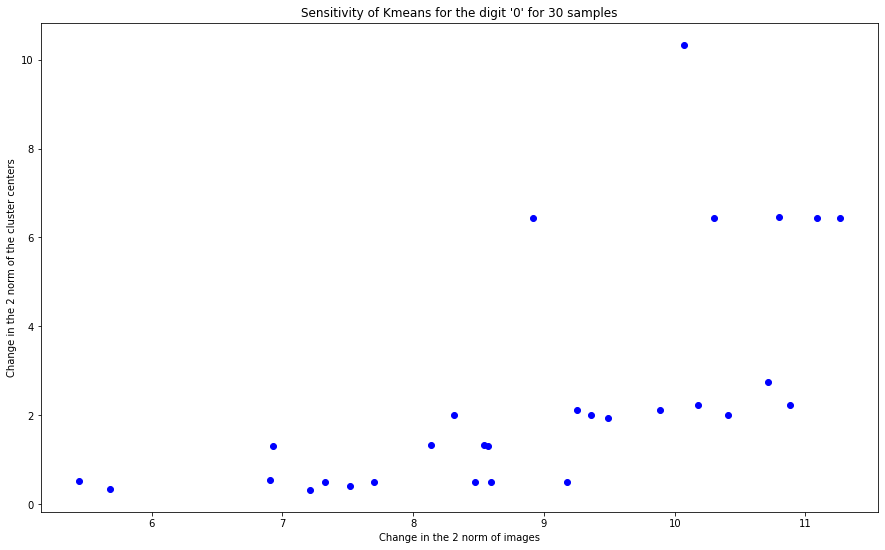

In [ ]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx0p,do0p, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '0' for 30 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

In the next few experiments, I see if this vertical gap in the middle is preserved as we increase the sample size.

In [23]:
#The lines of code below allow for randomly generating 25 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV0a = rng.integers(0, len(idv0), dtype=np.int32, size=25, endpoint=True)

dx0ea = []
ditV0ea = []
do0ea = []

for i in range(len(iV0a)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[0] != idv0[iV0a[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[0] = idv0[iV0a[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx0ea.append((np.linalg.norm(train_set[1,:] - train_set[idv0[iV0a[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV0ea.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do0ea.append(np.linalg.norm(Kmus_b - Kmus_t))

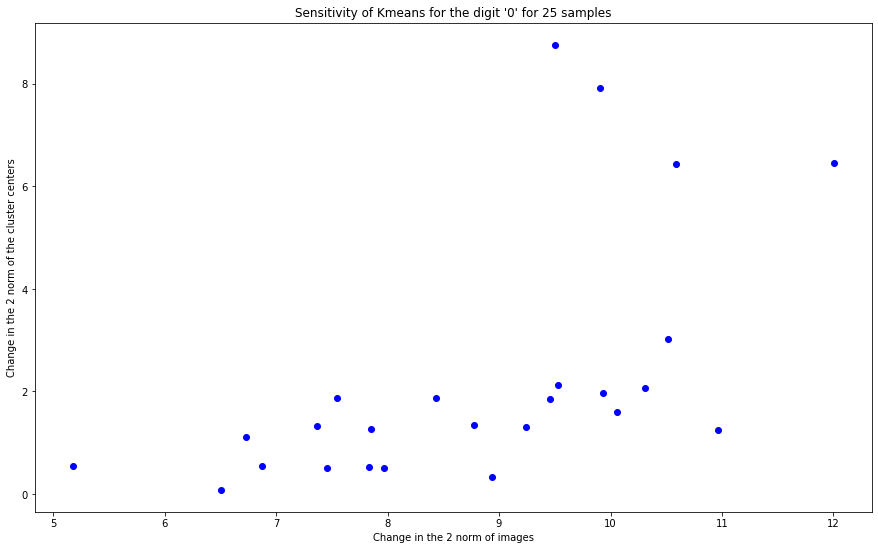

In [24]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx0ea,do0ea, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '0' for 25 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

In [25]:
#The lines of code below allow for randomly generating 50 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV0b = rng.integers(0, len(idv0), dtype=np.int32, size=50, endpoint=True)

dx0eb = []
ditV0eb = []
do0eb = []

for i in range(len(iV0b)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[0] != idv0[iV0b[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[0] = idv0[iV0b[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx0eb.append((np.linalg.norm(train_set[1,:] - train_set[idv0[iV0b[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV0eb.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do0eb.append(np.linalg.norm(Kmus_b - Kmus_t))

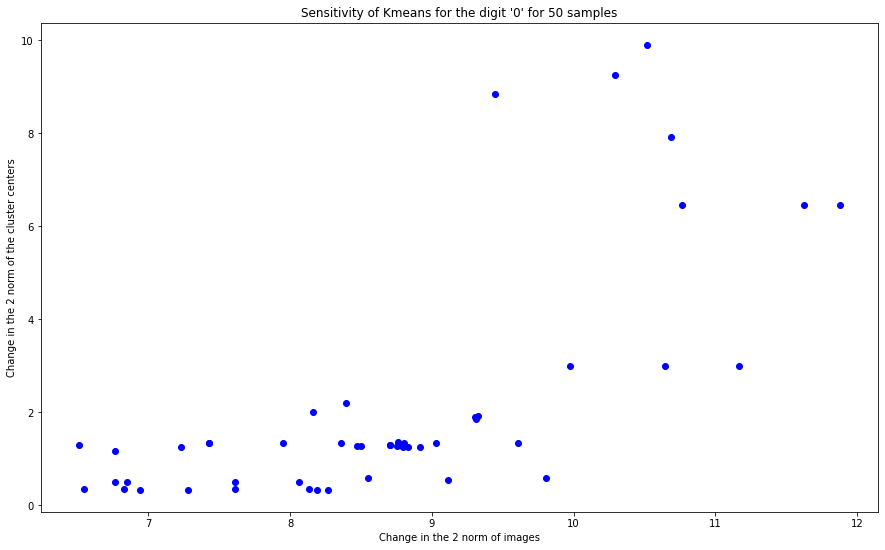

In [26]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx0eb,do0eb, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '0' for 50 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

In [27]:
#The lines of code below allow for randomly generating 75 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV0c = rng.integers(0, len(idv0), dtype=np.int32, size=75, endpoint=False)

dx0ec = []
ditV0ec = []
do0ec = []

for i in range(len(iV0c)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[0] != idv0[iV0c[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[0] = idv0[iV0c[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx0ec.append((np.linalg.norm(train_set[1,:] - train_set[idv0[iV0c[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV0ec.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do0ec.append(np.linalg.norm(Kmus_b - Kmus_t))

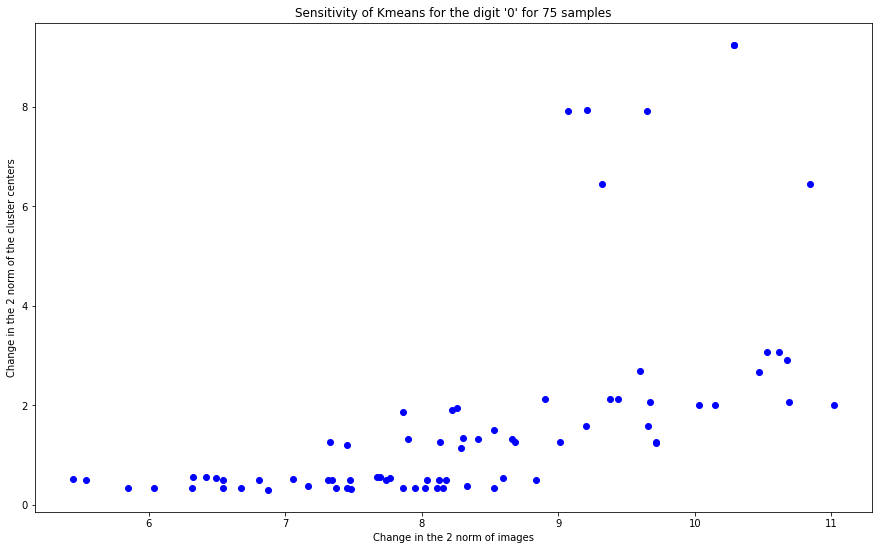

In [28]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx0ec,do0ec, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '0' for 75 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

In [20]:
#The lines of code below allow for randomly generating 100 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV0 = rng.integers(0, len(idv0), dtype=np.int32, size=100, endpoint=False)

dx0e = []
ditV0e = []
do0e = []

for i in range(len(iV0)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[0] != idv0[iV0[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[0] = idv0[iV0[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx0e.append((np.linalg.norm(train_set[1,:] - train_set[idv0[iV0[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV0e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do0e.append(np.linalg.norm(Kmus_b - Kmus_t))

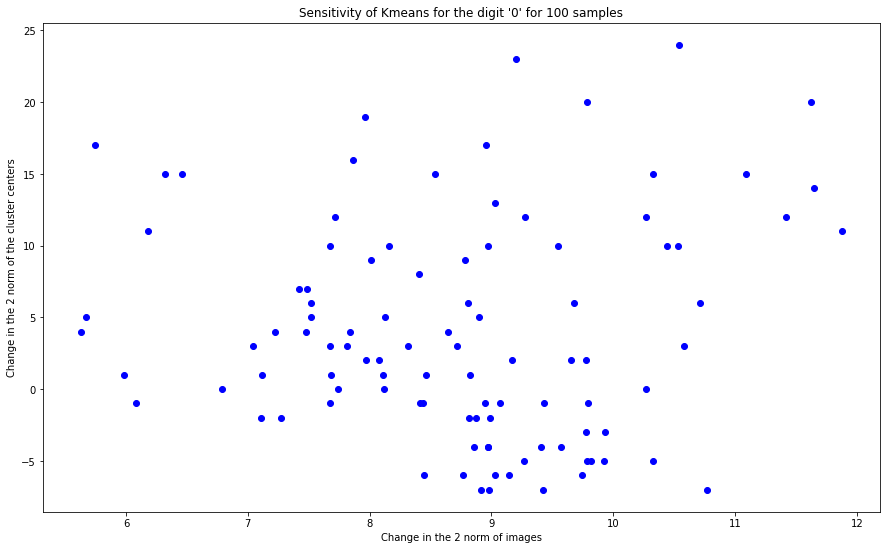

In [21]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx0e,ditV0e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '0' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

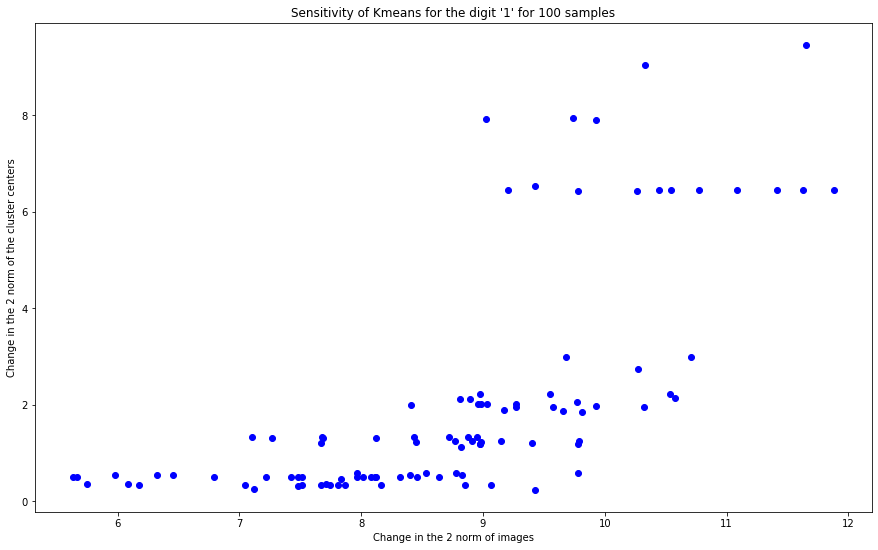

In [22]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx0e,do0e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '1' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

In [31]:
#The lines of code below allow for randomly generating 150 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV0d = rng.integers(0, len(idv0), dtype=np.int32, size=150, endpoint=False)

dx0ed = []
ditV0ed = []
do0ed = []

for i in range(len(iV0d)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[0] != idv0[iV0d[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[0] = idv0[iV0d[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx0ed.append((np.linalg.norm(train_set[1,:] - train_set[idv0[iV0d[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV0ed.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do0ed.append(np.linalg.norm(Kmus_b - Kmus_t))

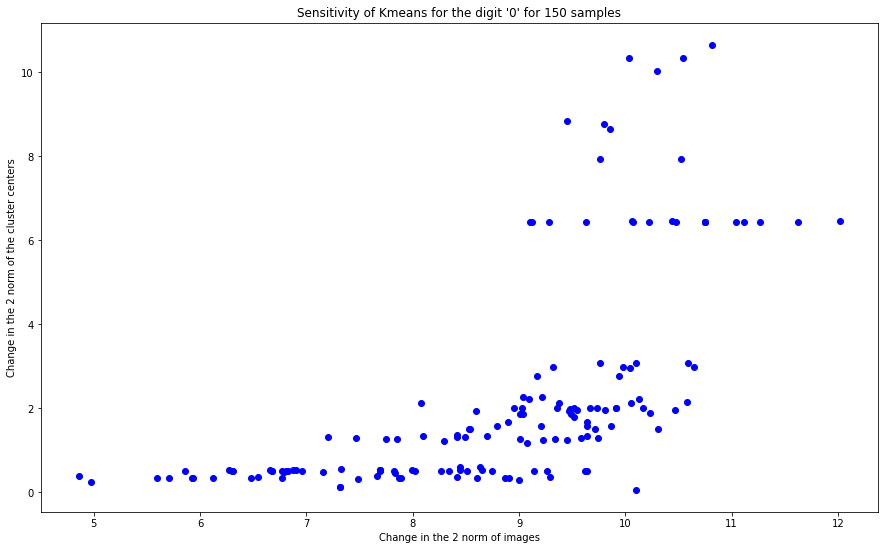

In [32]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx0ed,do0ed, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '0' for 150 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

In [40]:
#The lines of code below allow for randomly generating 100 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV1 = rng.integers(0, len(idv1), dtype=np.int32, size=100, endpoint=False)

dx1e = []
ditV1e = []
do1e = []

for i in range(len(iV1)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[1] != idv1[iV1[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[1] = idv1[iV1[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx1e.append((np.linalg.norm(train_set[8,:] - train_set[idv1[iV1[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV1e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do1e.append(np.linalg.norm(Kmus_b - Kmus_t))

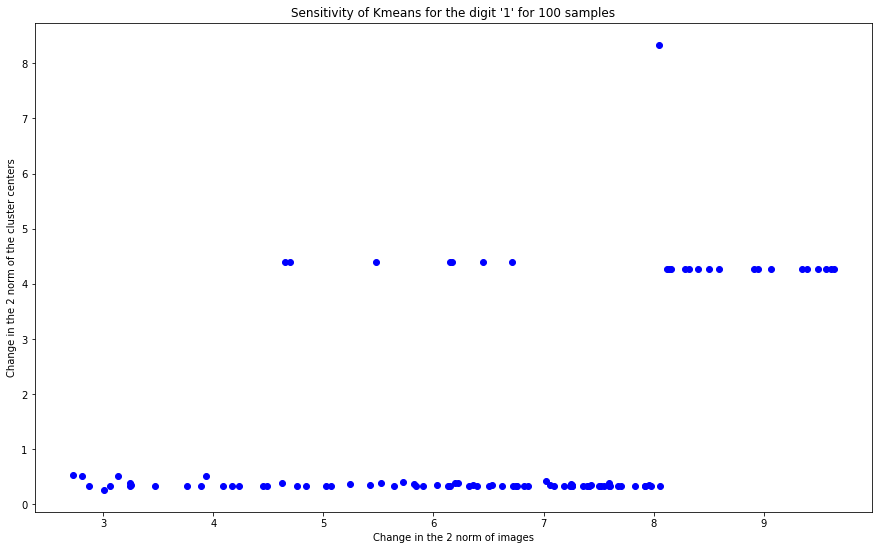

In [41]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx1e,do1e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '1' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

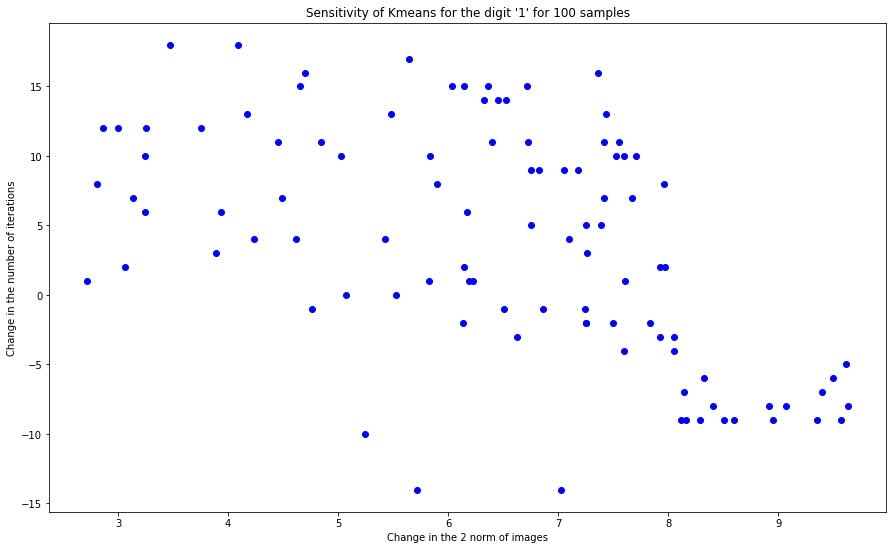

In [42]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx1e,ditV1e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '1' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [43]:
#The lines of code below allow for randomly generating 100 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV2 = rng.integers(0, len(idv2), dtype=np.int32, size=100, endpoint=False)

dx2e = []
ditV2e = []
do2e = []

for i in range(len(iV2)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[2] != idv2[iV2[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[2] = idv2[iV2[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx2e.append((np.linalg.norm(train_set[5,:] - train_set[idv2[iV2[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV2e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do2e.append(np.linalg.norm(Kmus_b - Kmus_t))

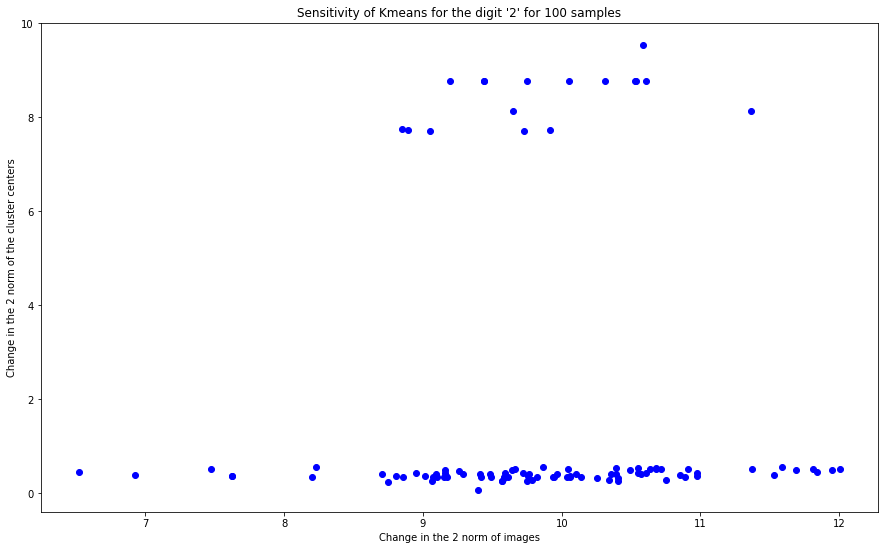

In [44]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx2e,do2e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '2' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

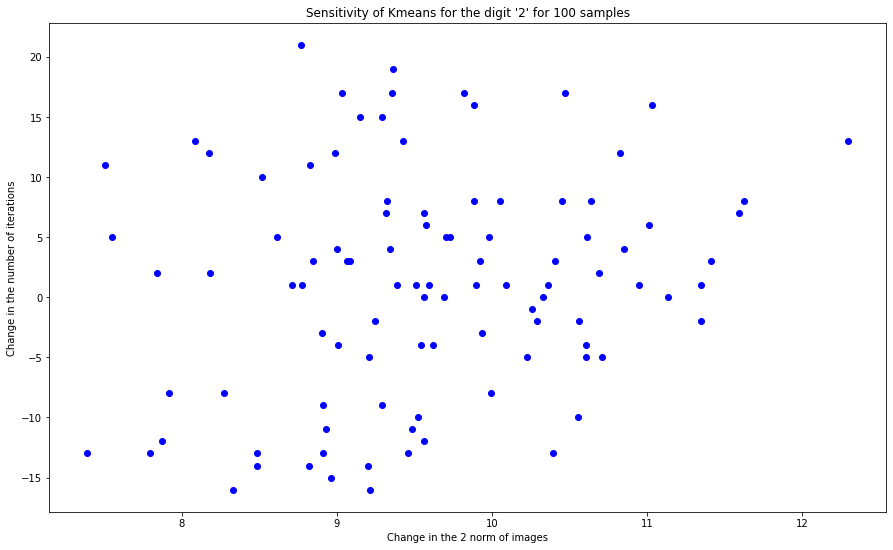

In [ ]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx2e,ditV2e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '2' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [ ]:
#The lines of code below allow for randomly generating 20 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV3 = rng.integers(0, len(idv3), dtype=np.int32, size=100, endpoint=False)

dx3e = []
ditV3e = []
do3e = []

for i in range(len(iV3)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[3] != idv3[iV3[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[3] = idv3[iV3[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx3e.append((np.linalg.norm(train_set[50,:] - train_set[idv3[iV3[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV3e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do3e.append(np.linalg.norm(Kmus_b - Kmus_t))

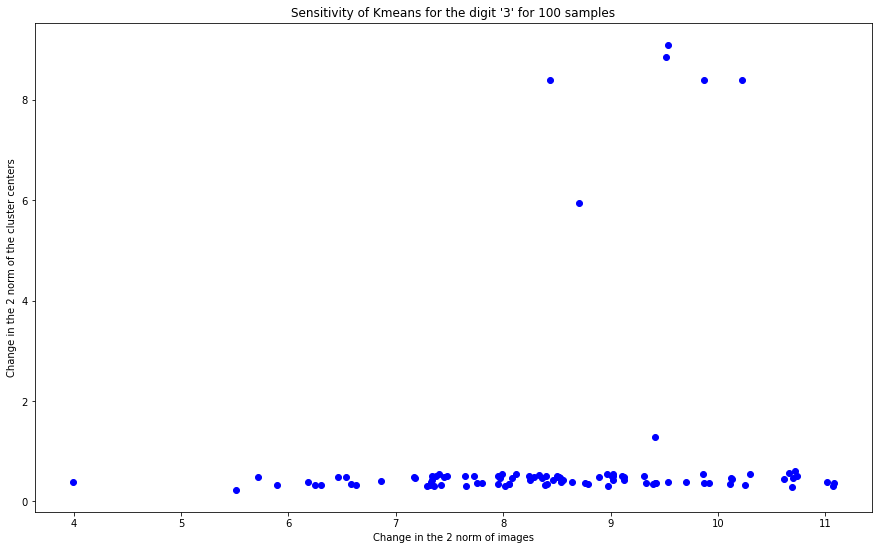

In [98]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx3e,do3e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '3' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

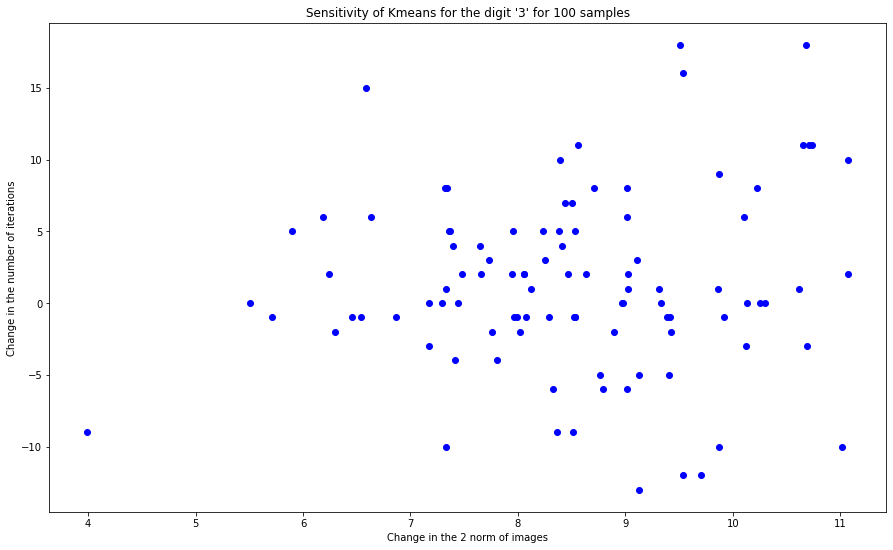

In [99]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx3e,ditV3e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '3' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [102]:
#The lines of code below allow for randomly generating 20 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV4 = rng.integers(0, len(idv4), dtype=np.int32, size=100, endpoint=False)

dx4e = []
ditV4e = []
do4e = []

for i in range(len(iV4)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[4] != idv4[iV4[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[4] = idv4[iV4[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx4e.append((np.linalg.norm(train_set[9,:] - train_set[idv4[iV4[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV4e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do4e.append(np.linalg.norm(Kmus_b - Kmus_t))

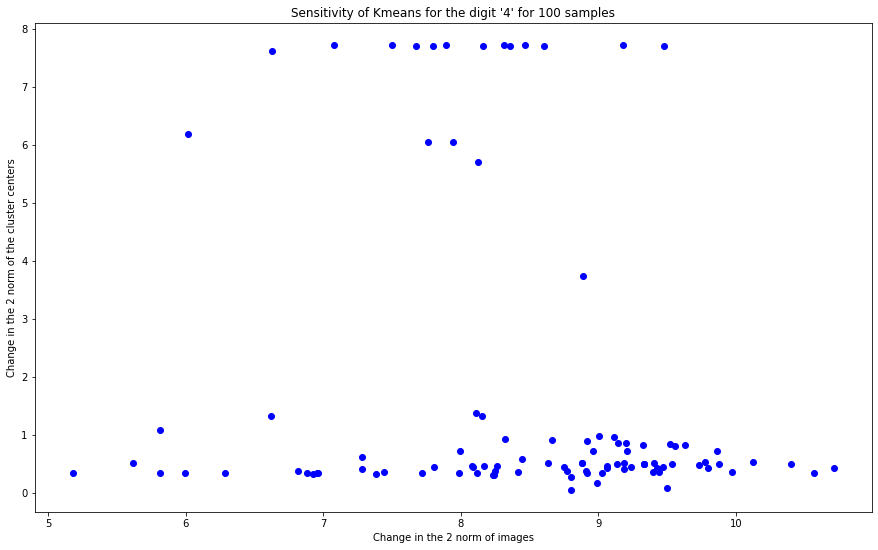

In [103]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx4e,do4e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '4' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

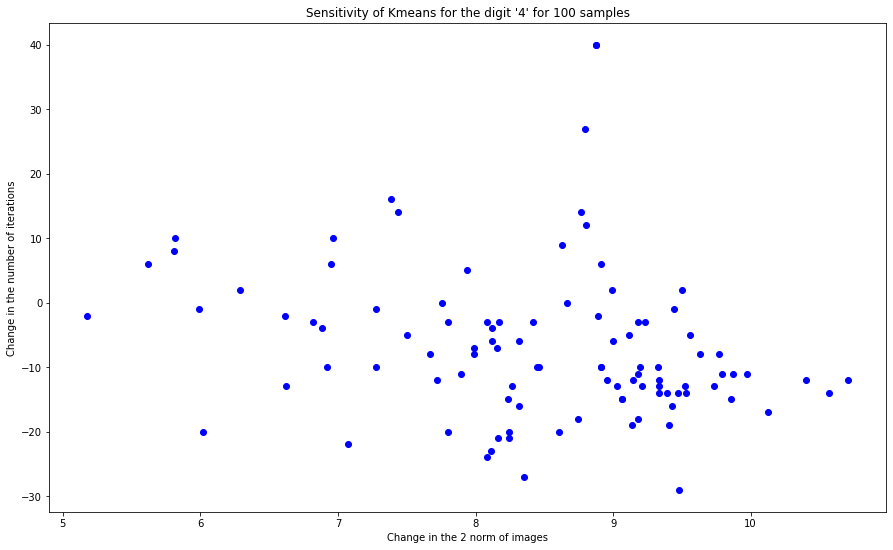

In [107]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx4e,ditV4e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '4' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [105]:
#The lines of code below allow for randomly generating 20 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV5 = rng.integers(0, len(idv5), dtype=np.int32, size=100, endpoint=False)

dx5e = []
ditV5e = []
do5e = []

In [106]:
for i in range(len(iV5)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[5] != idv5[iV5[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[5] = idv5[iV5[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx5e.append((np.linalg.norm(train_set[1635,:] - train_set[idv5[iV5[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV5e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do5e.append(np.linalg.norm(Kmus_b - Kmus_t))

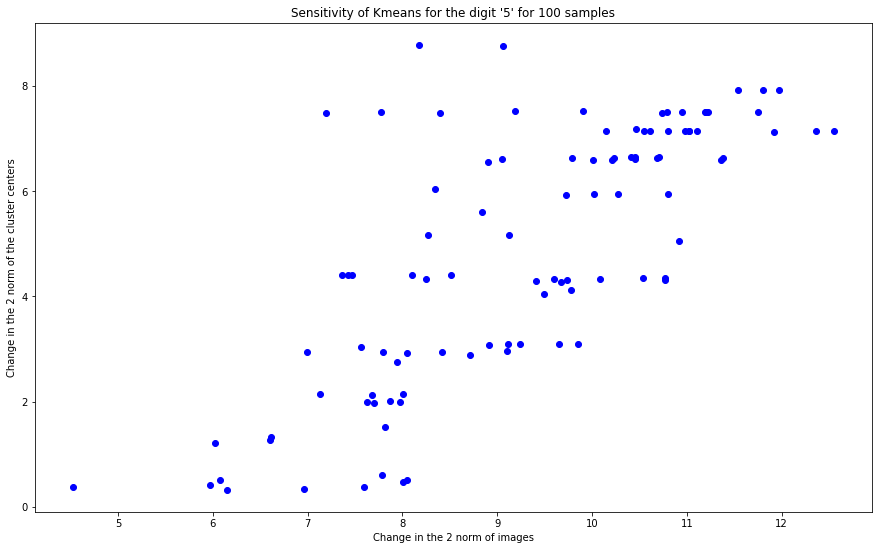

In [108]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx5e,do5e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '5' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

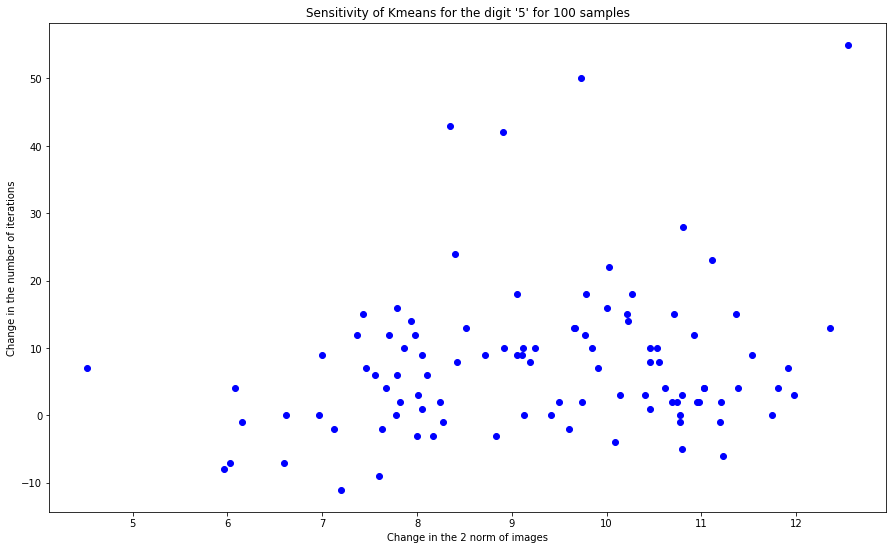

In [109]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx5e,ditV5e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '5' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [110]:
#The lines of code below allow for randomly generating 20 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV6 = rng.integers(0, len(idv6), dtype=np.int32, size=100, endpoint=False)

dx6e = []
ditV6e = []
do6e = []

In [111]:
for i in range(len(iV6)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[6] != idv6[iV6[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[6] = idv6[iV6[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx6e.append((np.linalg.norm(train_set[62,:] - train_set[idv6[iV6[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV6e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do6e.append(np.linalg.norm(Kmus_b - Kmus_t))

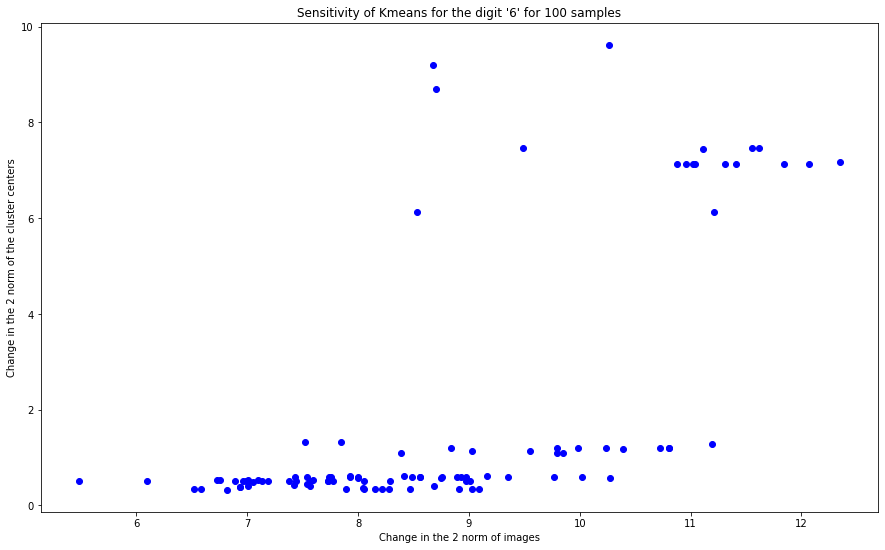

In [112]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx6e,do6e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '6' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

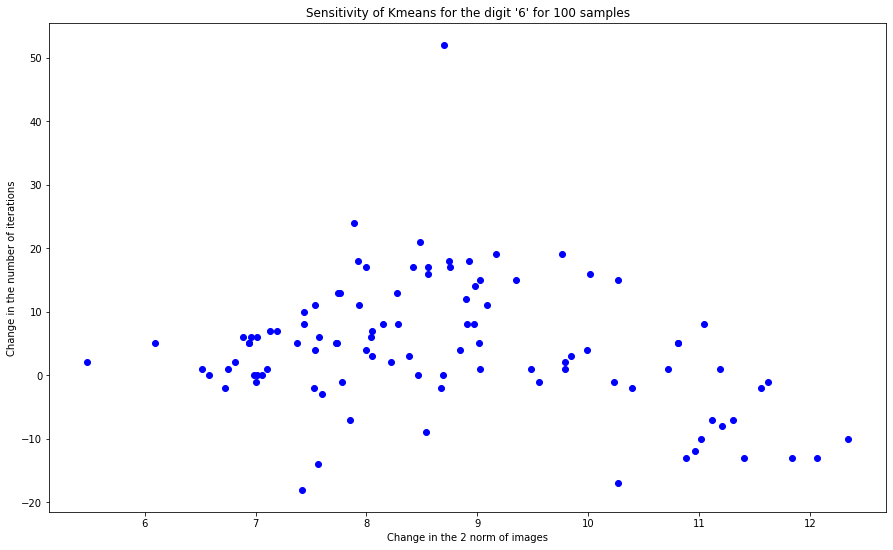

In [113]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx6e,ditV6e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '6' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [114]:
#The lines of code below allow for randomly generating 20 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV7 = rng.integers(0, len(idv7), dtype=np.int32, size=100, endpoint=False)

dx7e = []
ditV7e = []
do7e = []

In [115]:
for i in range(len(iV7)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[7] != idv7[iV7[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[7] = idv7[iV7[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx7e.append((np.linalg.norm(train_set[15,:] - train_set[idv7[iV7[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV7e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do7e.append(np.linalg.norm(Kmus_b - Kmus_t))

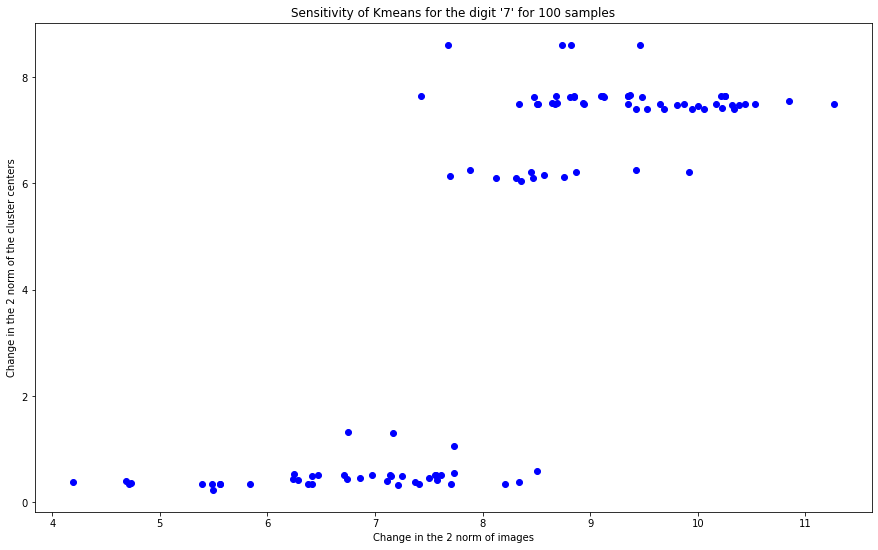

In [116]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx7e,do7e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '7' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

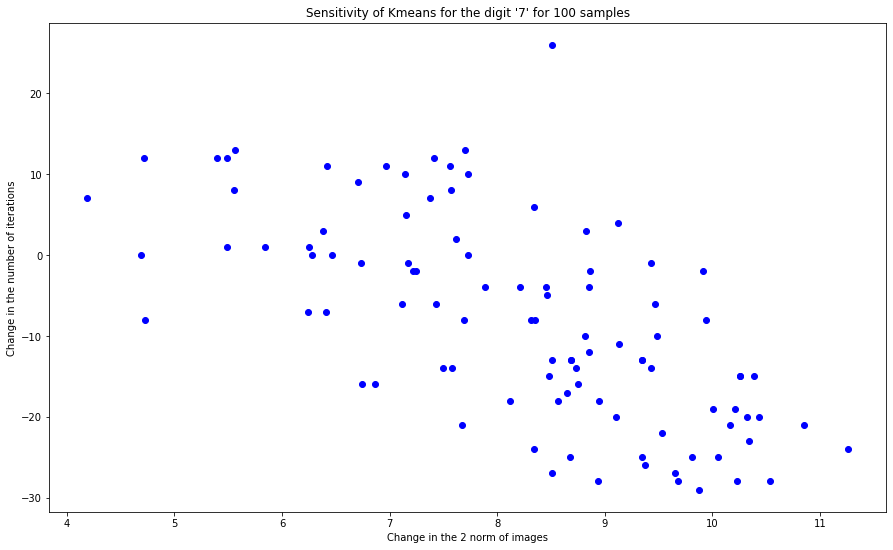

In [117]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx7e,ditV7e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '7' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [118]:
#The lines of code below allow for randomly generating 20 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV8 = rng.integers(0, len(idv8), dtype=np.int32, size=100, endpoint=False)

dx8e = []
ditV8e = []
do8e = []

In [119]:
for i in range(len(iV8)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[8] != idv8[iV8[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[8] = idv8[iV8[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx8e.append((np.linalg.norm(train_set[55,:] - train_set[idv8[iV8[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV8e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do8e.append(np.linalg.norm(Kmus_b - Kmus_t))

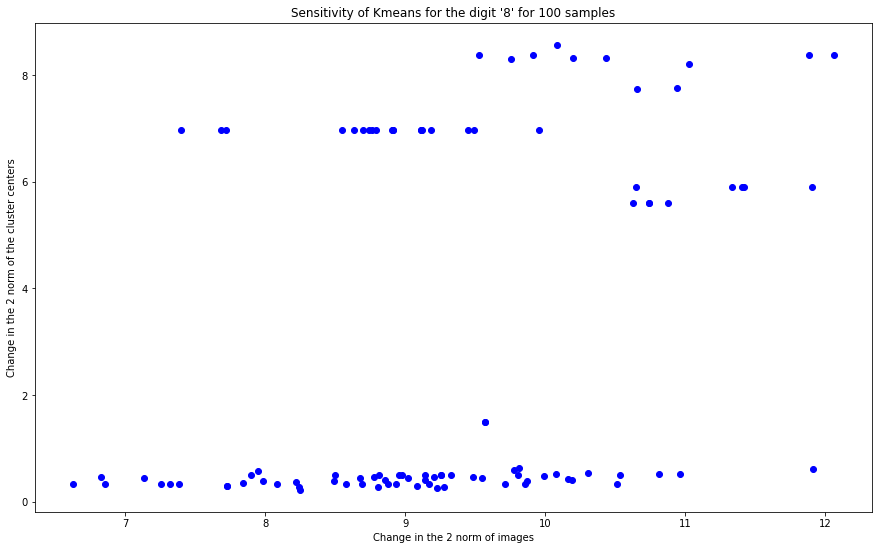

In [120]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx8e,do8e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '8' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

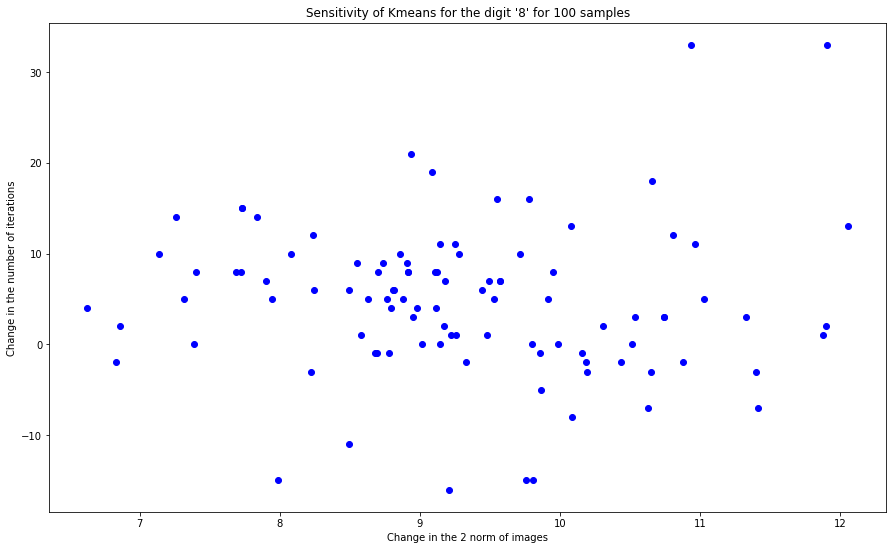

In [121]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx8e,ditV8e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '8' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [139]:
#The lines of code below allow for randomly generating 20 numbers
#uniformly on the interval (0, len(idv0))
rng = np.random.default_rng()
iV9 = rng.integers(0, len(idv9), dtype=np.int32, size=100, endpoint=False)

dx9e = []
ditV9e = []
do9e = []

In [140]:
for i in range(len(iV9)):
  #Indices for initla guess of cluster center from base
  initial_inds_b = np.array([1,8,5,50,9,1635,62,15,55,4])

  #We check that the new guess and the initial guess are not the same image
  if(initial_inds_b[9] != idv9[iV9[i]]):
    #Change the index from the base for the appropriate digit
    initial_inds_b[9] = idv9[iV9[i]]

    #Compute the pertrubation of the new digit image with respect to the base 
    #digit image and store it in a vector
    dx9e.append((np.linalg.norm(train_set[4,:] - train_set[idv9[iV9[i]],:])))

    #Run the kmeans algorithm with the new initial guess
    initial_Kmus_b= train_set[initial_inds_b[0:10],:]
    Kmus_t, ind_t = runKMeans_E(10, initial_Kmus_b)

    #Compute the absolute change in number of iterations
    ditV9e.append(ind_t - indc_b)

    #Compute the absolute change in the cluster means
    do9e.append(np.linalg.norm(Kmus_b - Kmus_t))

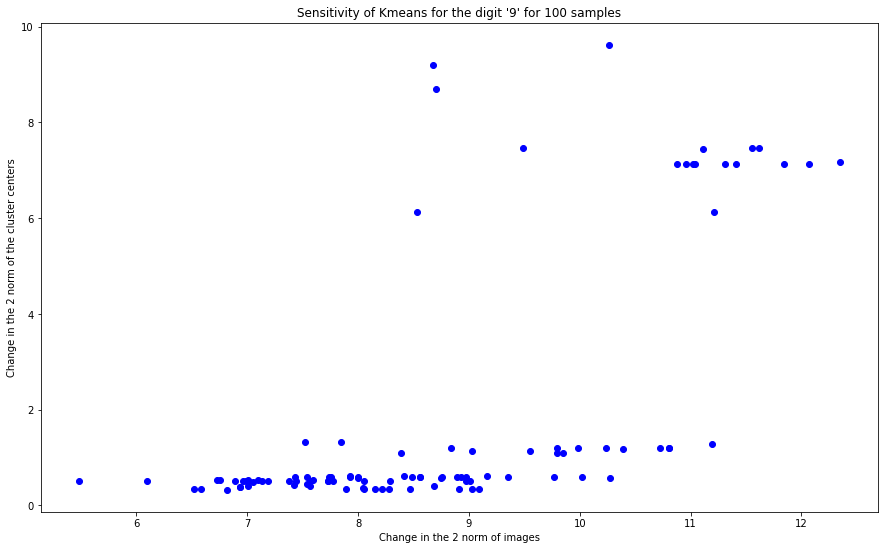

In [141]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx6e,do6e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '9' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the 2 norm of the cluster centers")
plt.show()

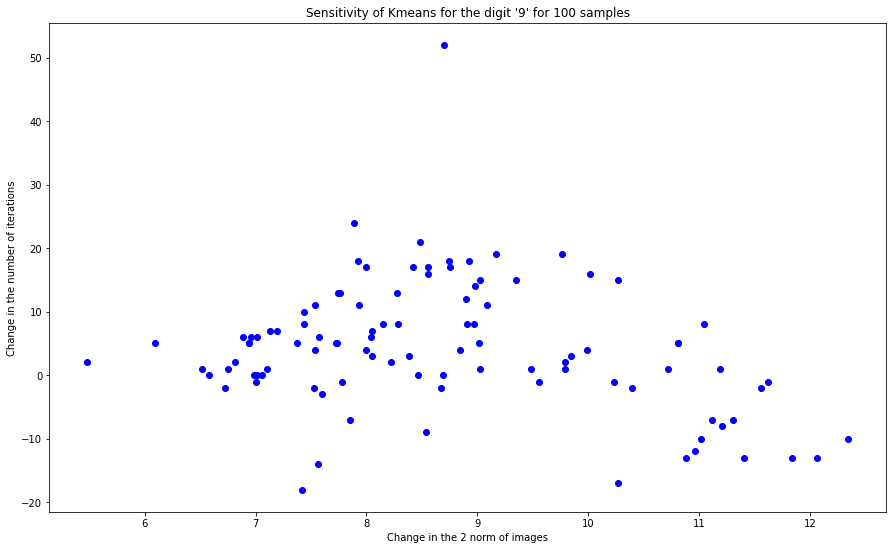

In [142]:
fig, axes = plt.subplots(figsize = (15,9))
axes.scatter(dx6e,ditV6e, fc='b')
pylab.title("Sensitivity of Kmeans for the digit '9' for 100 samples")
pylab.xlabel("Change in the 2 norm of images")
pylab.ylabel("Change in the number of iterations")
plt.show()

In [23]:
def runKMeans_R(K):
  (train_set, train_label), (test_set, test_label) = mnist.load_data()
  train_set, train_label = train_set[:10000], train_label[:10000]
  #Reshape the images as a 784d vector
  train_set = train_set.reshape(10000,-1)/255
  N = train_set.shape[0]
  #Get the 'length' of each data point. These are 28*28 images
  D = train_set.shape[1]

  #Allocate space for the K mu vectors
  Kmus = np.zeros((K,D))

  #Generate random indices, to initialize cluster centers
  rand_inds = np.random.permutation(N)
  Kmus = train_set[rand_inds[0:K],:]
  maxiters = 1000
  for iter in range(maxiters):
    sqDmat = calcSqDistances(train_set, Kmus)
    Rnk = determineRnk(sqDmat)
    KmusOld = Kmus
    Kmus = recalcMus(train_set, Rnk)
    
    if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
      break
  return iter

In [29]:
l_ind_dist_5 = []

for i in range(100):
  l_ind_dist_5.append(runKMeans_R(5))


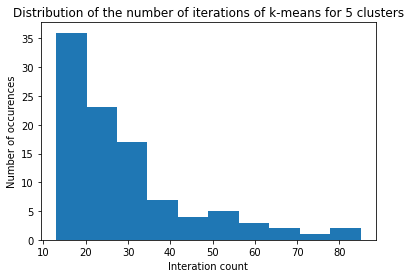

In [46]:
import matplotlib.pyplot as plt
plt.hist(l_ind_dist_5)
plt.xlabel('Iteration count')
plt.ylabel('Number of occurences')
plt.title('Distribution of the number of iterations of k-means for 5 clusters')
plt.show()

In [31]:
l_ind_dist_10 = []

for i in range(100):
  l_ind_dist_10.append(runKMeans_R(10))

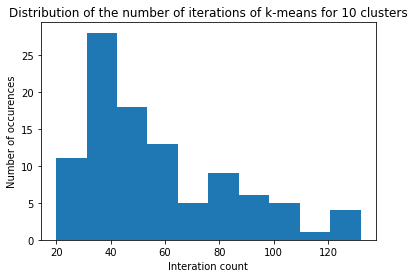

In [42]:
import matplotlib.pyplot as plt

plt.hist(l_ind_dist_10)
plt.xlabel('Iteration count')
plt.ylabel('Number of occurences')
plt.title('Distribution of the number of iterations of k-means for 10 clusters')
plt.show()

In [34]:
l_ind_dist_20 = []

for i in range(100):
  l_ind_dist_20.append(runKMeans_R(20))

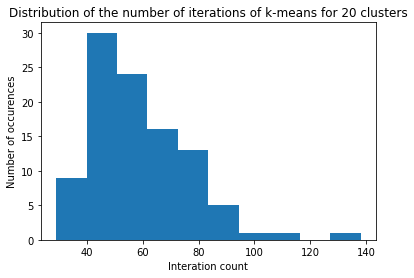

In [40]:
import matplotlib.pyplot as plt
plt.hist(l_ind_dist_20)
plt.xlabel('Interation count')
plt.ylabel('Number of occurences')
plt.title('Distribution of the number of iterations of k-means for 20 clusters')
plt.show()

In [47]:
l_ind_dist_5b = []

for i in range(200):
  l_ind_dist_5b.append(runKMeans_R(5))

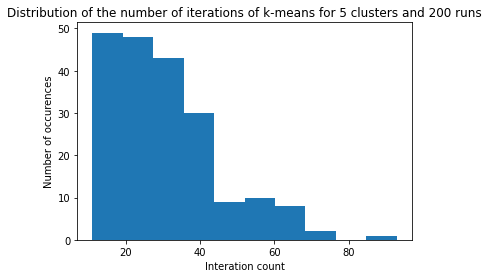

In [48]:
import matplotlib.pyplot as plt
plt.hist(l_ind_dist_5b)
plt.xlabel('Interation count')
plt.ylabel('Number of occurences')
plt.title('Distribution of the number of iterations of k-means for 5 clusters and 200 runs')
plt.show()

In [45]:
M = np.zeros((10,2))
M[0][1] = 2
print(M)

[[0. 2.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
